# Análisis Pancho

## 1) Importar librerías, importar datos, cambio tipo de dato variable "CodVendedor" y "ItemCode", ver dimensiones del df y tipología de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models.forecasting import fft
from darts.models.forecasting.arima import ARIMA
import datetime
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\silva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\silva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
df = pd.read_excel("SalesFact.xlsx").drop(columns = ['Cantidad (en UM de inventario)', 'Código de almacén de línea', 'CanalDeVenta'])
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,PrecioPorKilo,Kilombos
0,-3341.814208,C76825371,1003795,260502409101,4,2021-01-15,Mani Cubierta Chocolate Leche Bl. 5Kg,668.362842,-5.0
1,-3386.193577,C76825371,1003795,260501409102,4,2021-01-15,Mani Cubierta Chocolate Bitter Bl. 5Kg,677.238715,-5.0
2,-3548.000000,C77193123,1003291,260501409102,3,2020-08-26,Mani Cubierta Chocolate Bitter Bl. 5Kg,709.600000,-5.0
3,3803.000000,C76825371,1004246,140201409102,4,2021-04-12,Cranberry Entero Cubierta Chocolate Bitter Bl...,760.600000,5.0
4,-3803.000000,C76825371,1004223,140201409102,4,2021-04-12,Cranberry Entero Cubierta Chocolate Bitter Bl...,760.600000,-5.0


In [4]:
df.shape

(5963, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VentaNeta                 5963 non-null   float64       
 1   CodCliente                5963 non-null   object        
 2   Número de documento       5963 non-null   int64         
 3   ItemCode                  5963 non-null   int64         
 4   CodVendedor               5963 non-null   int64         
 5   Fecha                     5963 non-null   datetime64[ns]
 6   Descripción del artículo  5963 non-null   object        
 7   PrecioPorKilo             5963 non-null   float64       
 8   Kilombos                  5963 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 419.4+ KB


## 2) Crear variables:

- Materia Prima: Si es Almendra, Cranberry o Maní
- Chocolate: Si es envuelto en chocolate Leche o Bitter
- Formato: Qué tipo de formato de venta fue (5 kilos o 200g)

In [6]:
df['Descripción del artículo'].unique()

array(['Mani Cubierta Chocolate Leche Bl. 5Kg',
       'Mani Cubierta Chocolate Bitter Bl. 5Kg',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg',
       'Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg',
       'Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.',
       'Cranberry Cubierta Chocolate Leche Bl. 5Kg',
       'Mani Cubierta Chocolate Leche Bl. 200Gr.',
       'Mani Cubierta Chocolate Bitter Bl. 200Gr.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr.',
       'Cranberry Cubierta Chocolate Leche Bl. 200 Gr.',
       'Almendra Cubierta Con Chocolate De Leche Bl 200Gr.',
       'Almendra Cubierta Con Chocolate Bitter Bl 200Gr.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg',
       'Mani Cubierta Chocolate Leche Bl. 1Kg.',
       'Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.',
       'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg'], dtype=object)

In [7]:
df['MateriaPrima'] = np.where(df['Descripción del artículo'].str.find("Mani")>=0,"Maní",
                     np.where(df['Descripción del artículo'].str.find("Almendra")>=0,"Almendra",
                     np.where(df['Descripción del artículo'].str.find("Cranberry")>=0,"Cranberry","Otro")))

df.MateriaPrima.unique()

array(['Maní', 'Cranberry', 'Almendra'], dtype=object)

In [8]:
df['Chocolate'] = np.where(df['Descripción del artículo'].str.find("Bitter")>=0,"Bitter",
            np.where(df['Descripción del artículo'].str.find("Leche")>=0,"Leche","Otro"))
df.MateriaPrima.unique()

array(['Maní', 'Cranberry', 'Almendra'], dtype=object)

In [9]:
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '200 Gr', '1000 Gr'], dtype=object)

In [10]:
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,PrecioPorKilo,Kilombos,MateriaPrima,Chocolate,Formato
0,-3341.814208,C76825371,1003795,260502409101,4,2021-01-15,Mani Cubierta Chocolate Leche Bl. 5Kg,668.362842,-5.0,Maní,Leche,5000 Gr
1,-3386.193577,C76825371,1003795,260501409102,4,2021-01-15,Mani Cubierta Chocolate Bitter Bl. 5Kg,677.238715,-5.0,Maní,Bitter,5000 Gr
2,-3548.000000,C77193123,1003291,260501409102,3,2020-08-26,Mani Cubierta Chocolate Bitter Bl. 5Kg,709.600000,-5.0,Maní,Bitter,5000 Gr
3,3803.000000,C76825371,1004246,140201409102,4,2021-04-12,Cranberry Entero Cubierta Chocolate Bitter Bl...,760.600000,5.0,Cranberry,Bitter,5000 Gr
4,-3803.000000,C76825371,1004223,140201409102,4,2021-04-12,Cranberry Entero Cubierta Chocolate Bitter Bl...,760.600000,-5.0,Cranberry,Bitter,5000 Gr


In [11]:
df.groupby(['MateriaPrima', 'Chocolate', 'Formato'])['Kilombos'].agg(['sum', 'count'])

sum  count
MateriaPrima Chocolate Formato                
Almendra     Bitter    1000 Gr      1.0      1
                       200 Gr     587.6    102
                       5000 Gr   9270.0   1069
             Leche     1000 Gr      1.0      1
                       200 Gr     526.2     83
                       5000 Gr   7160.0    733
Cranberry    Bitter    1000 Gr      1.0      1
                       200 Gr     776.8    105
                       5000 Gr  12535.0   1318
             Leche     200 Gr     413.4     74
                       5000 Gr   7140.0    657
Maní         Bitter    200 Gr     616.0     85
                       5000 Gr   7420.0    897
             Leche     1000 Gr      1.0      1
                       200 Gr     692.8     89
                       5000 Gr   7505.0    747

## 3) Limpieza de datos

1.  Dejamos sólo las variables 'Fecha' y 'Kilos' (Cambiando de nombre la variable 'kilombos')
2.  Creamos la variable 'Año' y 'Semana' (Con semana empezando por día lunes)
3.  Creamos la variable 'Año-Semana'
4.  Dejamos solo la data desde 2019-04-15 en adelante (ya que hay semanas hacia atrás de esto que tienen ventas 0, impidiendo modelos asumiendo aditividad)
5.  Dejamos sólo semanas completas, para obtener las 138 semanas de dataset y predecir las últimas 12 (3 meses)
6.  Sacamos los Outliers por 2,3,4,5 Desvest

## Pasos 1,2,3,4,5

In [12]:
df = df[df.Formato != '1000 Gr']
df['MateriaPrimaChocolate'] = df['MateriaPrima']+df['Chocolate']
df = df[['Fecha', 'Kilombos', 'MateriaPrimaChocolate']].rename(columns={'Kilombos':'Kilos'})
df['Año'] = df['Fecha'].dt.year
df['Semana'] = np.where(df['Fecha'].dt.isocalendar().week<10, str(0) + df['Fecha'].dt.isocalendar().week.astype('str'), df['Fecha'].dt.isocalendar().week.astype('object'))
df['Mes'] = np.where(df['Fecha'].dt.month <10, str(0) + df['Fecha'].dt.month.astype('str'), df['Fecha'].dt.month.astype('object'))
df['Año-Semana'] = df['Año'].astype('str') + '-' + df['Semana'].astype('str')
df['Año-Semana'] = df['Año-Semana'].replace({'2019-01':'2020-01'})
df['Año-Mes'] = df['Año'].astype('str') + '-' + df['Mes'].astype('str')
df = df[df['Fecha'] >= '2020-03-01']
df = df[df['Fecha'] < '2021-12-01']
df['Quincena'] = np.where(df['Fecha'].dt.day <=15, "1° Quincena", "2°Quincena" )
df['Año-Mes-Quincena'] = df['Año'].astype('str') + '-' + df['Mes'].astype('str') + '-' + df['Quincena'].astype('str')
df = df.sort_values(by = 'Año-Mes-Quincena', ascending = True)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes,Quincena,Año-Mes-Quincena
1996,2020-03-12,5.0,CranberryBitter,2020,11,03,2020-11,2020-03,1° Quincena,2020-03-1° Quincena
1993,2020-03-02,5.0,CranberryBitter,2020,10,03,2020-10,2020-03,1° Quincena,2020-03-1° Quincena
1994,2020-03-05,5.0,CranberryBitter,2020,10,03,2020-10,2020-03,1° Quincena,2020-03-1° Quincena
1995,2020-03-11,5.0,CranberryBitter,2020,11,03,2020-11,2020-03,1° Quincena,2020-03-1° Quincena
4514,2020-03-05,5.0,AlmendraLeche,2020,10,03,2020-10,2020-03,1° Quincena,2020-03-1° Quincena


In [13]:
len(df['Año-Mes-Quincena'].unique())

42

## Paso 6) Sacamos los Outliers por 2 , 3, 3.5, 4 y 5 Desvest (sacadas por Año-Mes-Quincena), y luego se limpia cada registro según mean+-desvest que dió para cada año-Mes-Quincena

In [14]:
# Código de Benja

# Identificamos la media y desviacion estandar por quincena
df_sales_SM= pd.DataFrame()
df_sales_SM=y = df.groupby(['Año-Mes-Quincena']).agg({'Kilos' : ['mean', 'std']})
df_sales_SM.columns = ['mean', 'std']
df_sales_SM = df_sales_SM.reset_index().fillna(0) #Se vuelve a dejar "Año--Mes-Semana" como columna. La semana 2019-25 tiene sólo 1 registro por lo que la desviación estándar da NAN

#Cruzamos con el dataframe recién guardado
df = pd.merge(df, df_sales_SM, on ='Año-Mes-Quincena', how='left')
df = df.sort_values(by = 'Año-Mes', ascending = True)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes,Quincena,Año-Mes-Quincena,mean,std
0,2020-03-12,5.0,CranberryBitter,2020,11,03,2020-11,2020-03,1° Quincena,2020-03-1° Quincena,7.870370,4.514322
80,2020-03-24,15.0,CranberryBitter,2020,13,03,2020-13,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464
79,2020-03-17,10.0,CranberryBitter,2020,12,03,2020-12,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464
78,2020-03-30,5.0,CranberryLeche,2020,14,03,2020-14,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464
77,2020-03-17,5.0,AlmendraLeche,2020,12,03,2020-12,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464


In [15]:
df.shape

(5415, 12)

(-75.0, 75.0)

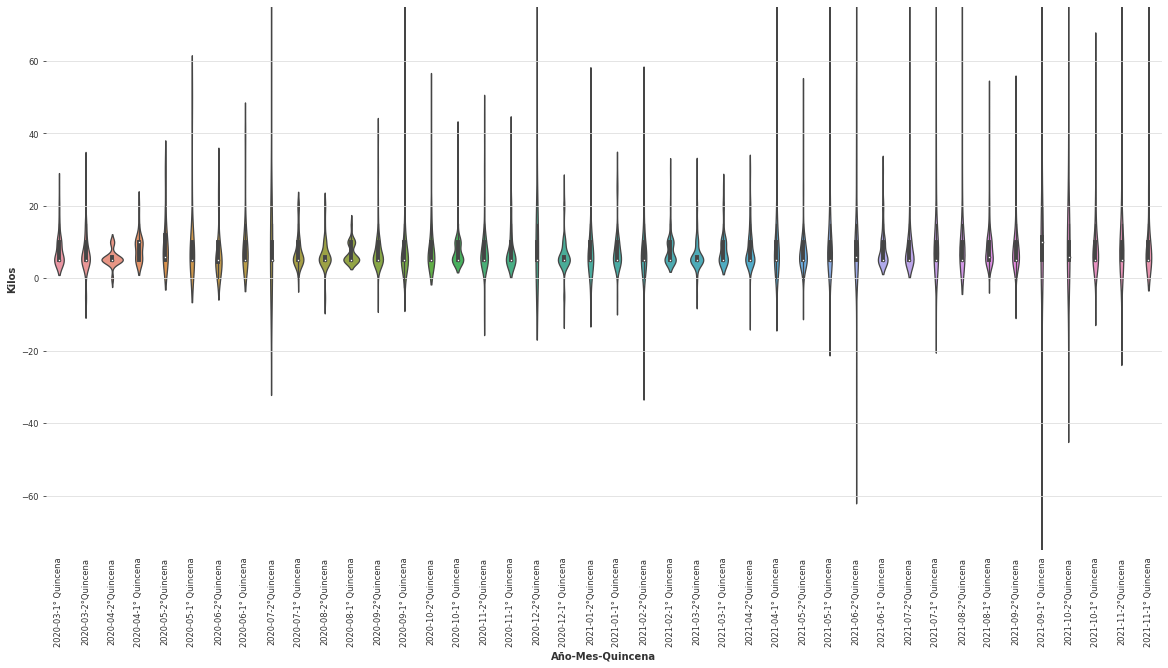

In [16]:
plt.rcParams['figure.figsize'] =(20,10)
sns.violinplot(data = df, x='Año-Mes-Quincena', y='Kilos')
plt.xticks(rotation=90)
plt.ylim(-75,75)

(-25.0, 25.0)

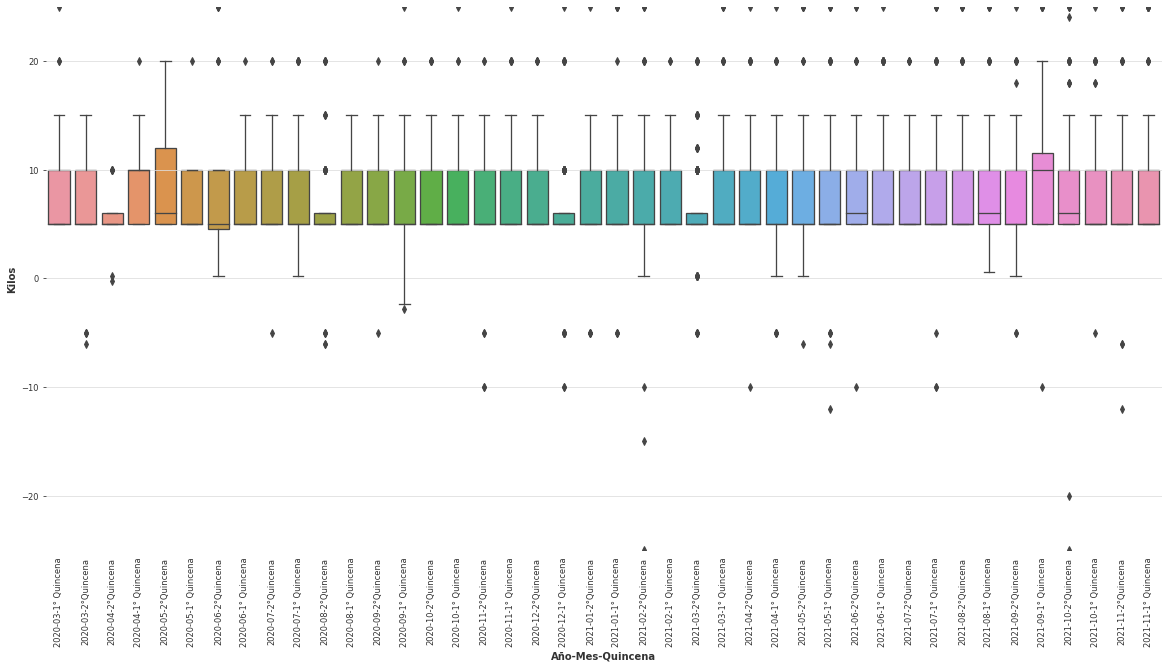

In [17]:
plt.rcParams['figure.figsize'] =(20,10)
sns.boxplot(data = df, x='Año-Mes-Quincena', y='Kilos', orient='v')
plt.xticks(rotation=90)
plt.ylim(-25,25)

In [18]:
#Definimos si es outlier o no en base a 3, 4 y 5 desviaciones estándar
df['Kilos_2DV'] = np.where((df.Kilos > (df['mean'] + 2*df['std'])) | (df.Kilos < (df['mean'] - 2*df['std'])), 1, 0)
df['Kilos_3DV'] = np.where((df.Kilos > (df['mean'] + 3*df['std'])) | (df.Kilos < (df['mean'] - 3*df['std'])), 1, 0)
df['Kilos_35DV'] = np.where((df.Kilos > (df['mean'] + 3.5*df['std'])) | (df.Kilos < (df['mean'] - 3.5*df['std'])), 1, 0)
df['Kilos_4DV'] = np.where((df.Kilos > (df['mean'] + 4*df['std'])) | (df.Kilos < (df['mean'] - 4*df['std'])), 1, 0)
df['Kilos_5DV'] = np.where((df.Kilos > (df['mean'] + 5*df['std'])) | (df.Kilos < (df['mean'] - 5*df['std'])), 1, 0)
df['Kilos_7DV'] = np.where((df.Kilos > (df['mean'] + 7*df['std'])) | (df.Kilos < (df['mean'] - 7*df['std'])), 1, 0)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes,Quincena,Año-Mes-Quincena,mean,std,Kilos_2DV,Kilos_3DV,Kilos_35DV,Kilos_4DV,Kilos_5DV,Kilos_7DV
0,2020-03-12,5.0,CranberryBitter,2020,11,03,2020-11,2020-03,1° Quincena,2020-03-1° Quincena,7.870370,4.514322,0,0,0,0,0,0
80,2020-03-24,15.0,CranberryBitter,2020,13,03,2020-13,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464,0,0,0,0,0,0
79,2020-03-17,10.0,CranberryBitter,2020,12,03,2020-12,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464,0,0,0,0,0,0
78,2020-03-30,5.0,CranberryLeche,2020,14,03,2020-14,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464,0,0,0,0,0,0
77,2020-03-17,5.0,AlmendraLeche,2020,12,03,2020-12,2020-03,2°Quincena,2020-03-2°Quincena,6.535714,5.470464,0,0,0,0,0,0


In [19]:
# Mostramos la cantidad de outliers que saca por cada caso
df.sum()

Kilos                                                              49952.6
MateriaPrimaChocolate    CranberryBitterCranberryBitterCranberryBitterC...
Año                                                               10942153
Año-Semana               2020-112020-132020-122020-142020-122020-122020...
Año-Mes                  2020-032020-032020-032020-032020-032020-032020...
Quincena                 1° Quincena2°Quincena2°Quincena2°Quincena2°Qui...
Año-Mes-Quincena         2020-03-1° Quincena2020-03-2°Quincena2020-03-2...
mean                                                               49952.6
std                                                           61026.057561
Kilos_2DV                                                              292
Kilos_3DV                                                              120
Kilos_35DV                                                              81
Kilos_4DV                                                               52
Kilos_5DV                

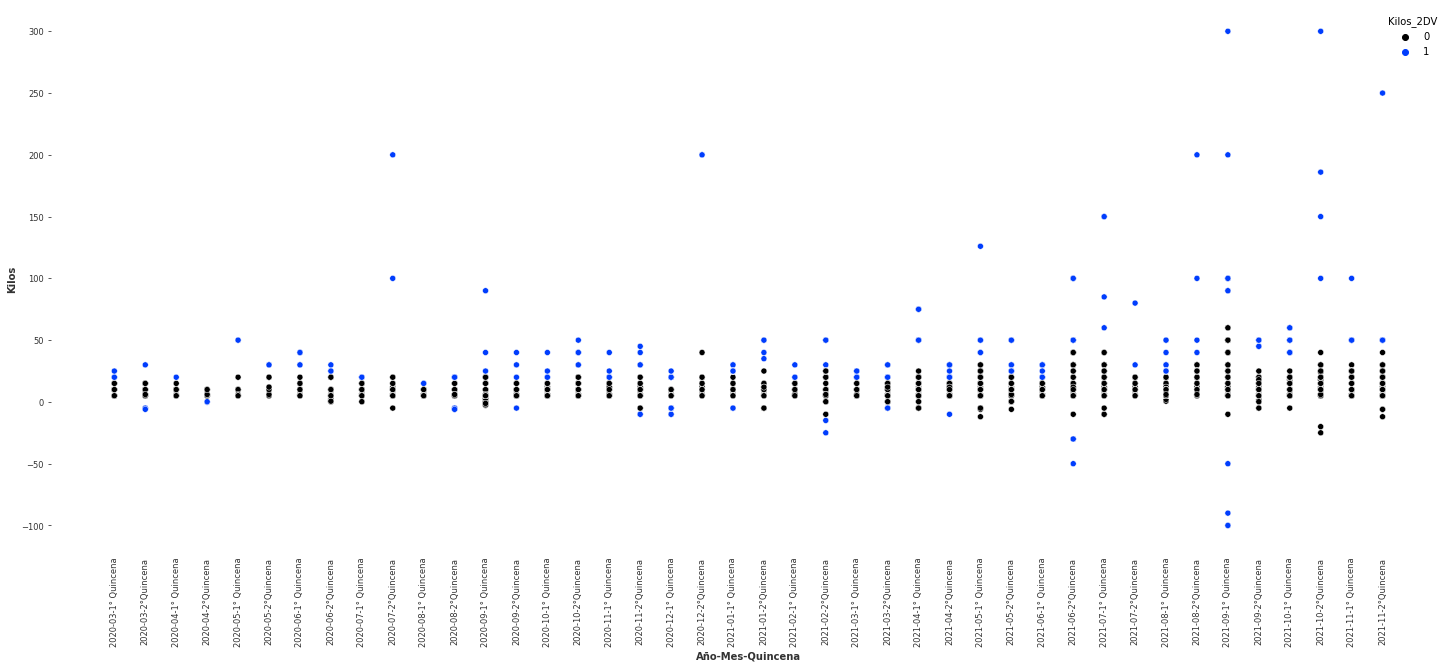

In [20]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Mes-Quincena', ascending=True)
sns.scatterplot(data=df, x = 'Año-Mes-Quincena', y = 'Kilos', hue= 'Kilos_2DV', ax = ax)
plt.xticks(rotation=90);

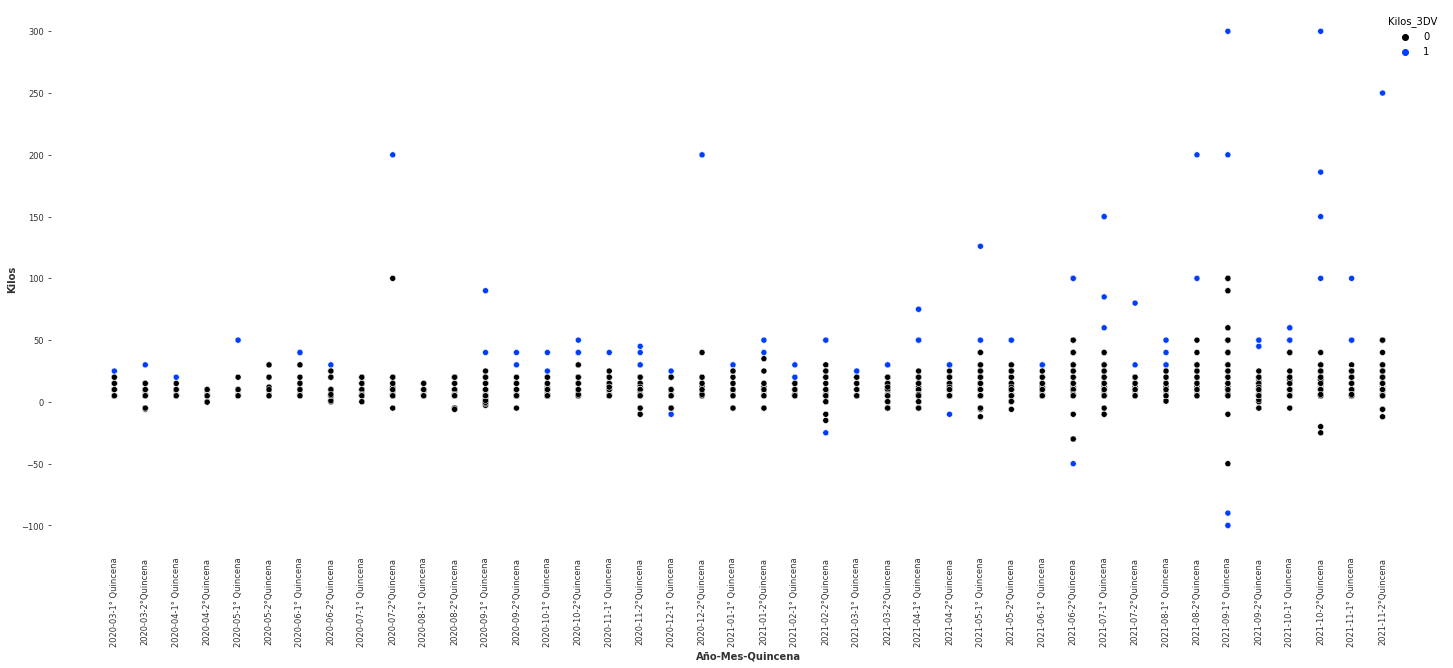

In [21]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Mes-Quincena', ascending=True)
sns.scatterplot(data=df, x = 'Año-Mes-Quincena', y = 'Kilos', hue= 'Kilos_3DV', ax = ax)
plt.xticks(rotation=90);

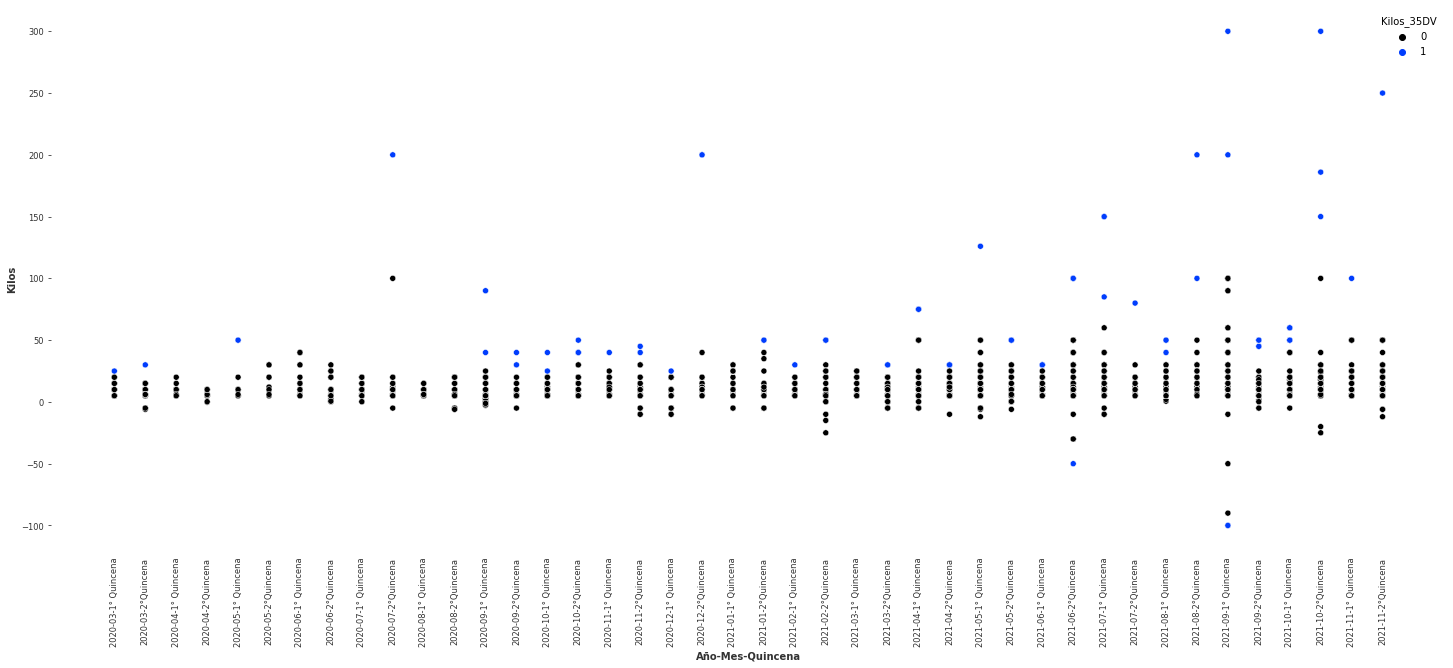

In [22]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Mes-Quincena', ascending=True)
sns.scatterplot(data=df, x = 'Año-Mes-Quincena', y = 'Kilos', hue= 'Kilos_35DV', ax = ax)
plt.xticks(rotation=90);

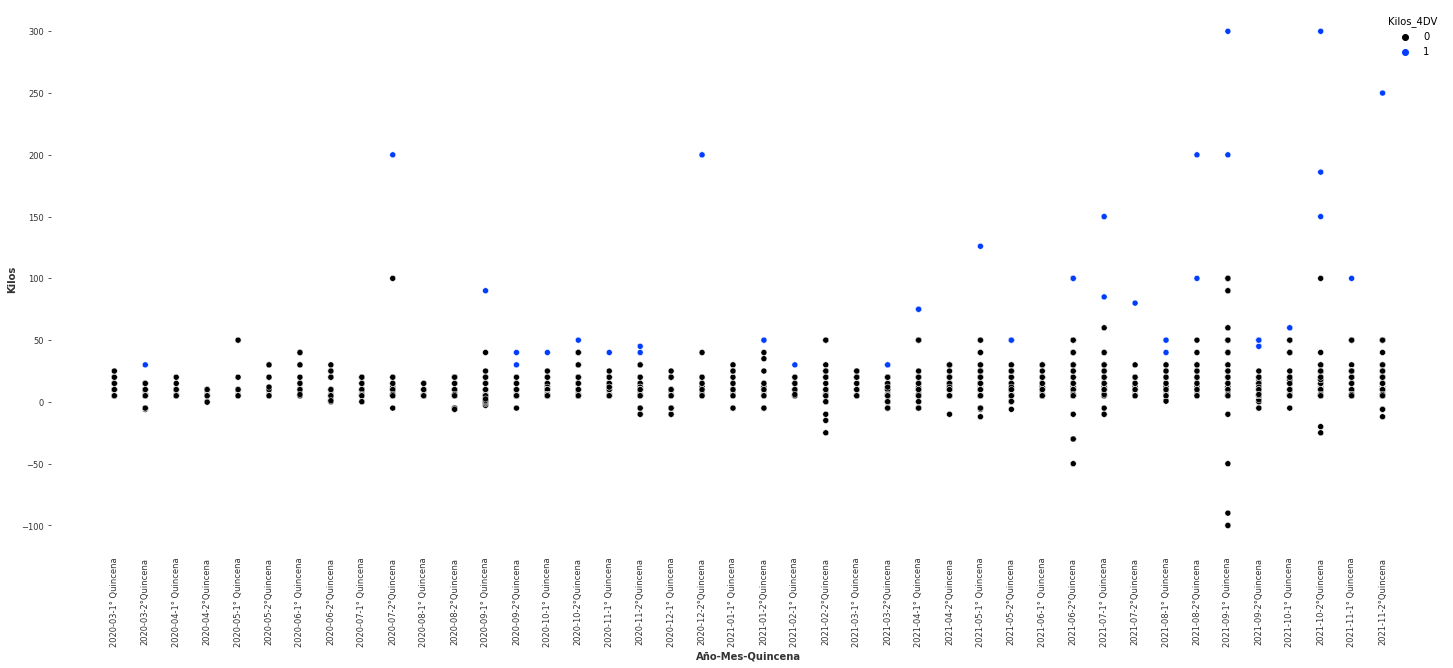

In [23]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Mes-Quincena', ascending=True)
sns.scatterplot(data=df, x = 'Año-Mes-Quincena', y = 'Kilos', hue= 'Kilos_4DV', ax = ax)
plt.xticks(rotation=90);

## Generamos los dataset con cada caso, cada uno sin outliers según corresponda

In [24]:
df2dv = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()
df3dv = df[df['Kilos_3DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()
df35dv = df[df['Kilos_35DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()
df4dv = df[df['Kilos_4DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()
df5dv = df[df['Kilos_5DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()
df7dv = df[df['Kilos_7DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos']].set_index('Fecha').resample('SM', label='left').sum().reset_index()

df2dv.head()

,Fecha,Kilos
0,2020-02-29,360.0
1,2020-03-15,357.0
2,2020-03-31,165.0
3,2020-04-15,207.0
4,2020-04-30,181.0


In [25]:
AB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
AB = AB[AB['MateriaPrimaChocolate']=="AlmendraBitter"].resample('SM', label='left').sum().rename(columns= {'Kilos':'AlmendraBitter'})

AL = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
AL = AL[AL['MateriaPrimaChocolate']=="AlmendraLeche"].resample('SM', label='left').sum().rename(columns={'Kilos':'AlmendraLeche'})

CB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
CB = CB[CB['MateriaPrimaChocolate']=="CranberryBitter"].resample('SM', label='left').sum().rename(columns={'Kilos':'CranberryBitter'})

CL= df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
CL = CL[CL['MateriaPrimaChocolate']=="CranberryLeche"].resample('SM', label='left').sum().rename(columns={'Kilos':'CranberryLeche'})

MB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
MB = MB[MB['MateriaPrimaChocolate']=="ManíBitter"].resample('SM', label='left').sum().rename(columns={'Kilos':'ManíBitter'})

ML = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes-Quincena', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
ML = ML[ML['MateriaPrimaChocolate']=="ManíLeche"].resample('SM', label='left').sum().rename(columns={'Kilos':'ManíLeche'})

print(AB.shape)
print(AL.shape)
print(CB.shape)
print(CL.shape)
print(MB.shape)
print(ML.shape)

(43, 1)
(43, 1)
(43, 1)
(43, 1)
(43, 1)
(43, 1)


In [26]:
matrix = pd.concat([AB,AL,CB,CL,MB,ML], axis=1).fillna(0)
matrix['Total'] = matrix['AlmendraBitter']+ matrix['AlmendraLeche']+matrix['CranberryBitter']+matrix['CranberryLeche']+matrix['ManíBitter']+matrix['ManíLeche']
matrix.head()

,AlmendraBitter,AlmendraLeche,CranberryBitter,CranberryLeche,ManíBitter,ManíLeche,Total
Fecha,,,,,,,
2020-02-29,105.0,30.0,95.0,40.0,60.0,30.0,360.0
2020-03-15,92.0,51.0,106.0,41.0,41.0,26.0,357.0
2020-03-31,65.0,10.0,40.0,10.0,40.0,0.0,165.0
2020-04-15,21.0,52.0,46.0,16.0,36.0,36.0,207.0
2020-04-30,55.0,10.0,46.0,25.0,20.0,25.0,181.0


<AxesSubplot:>

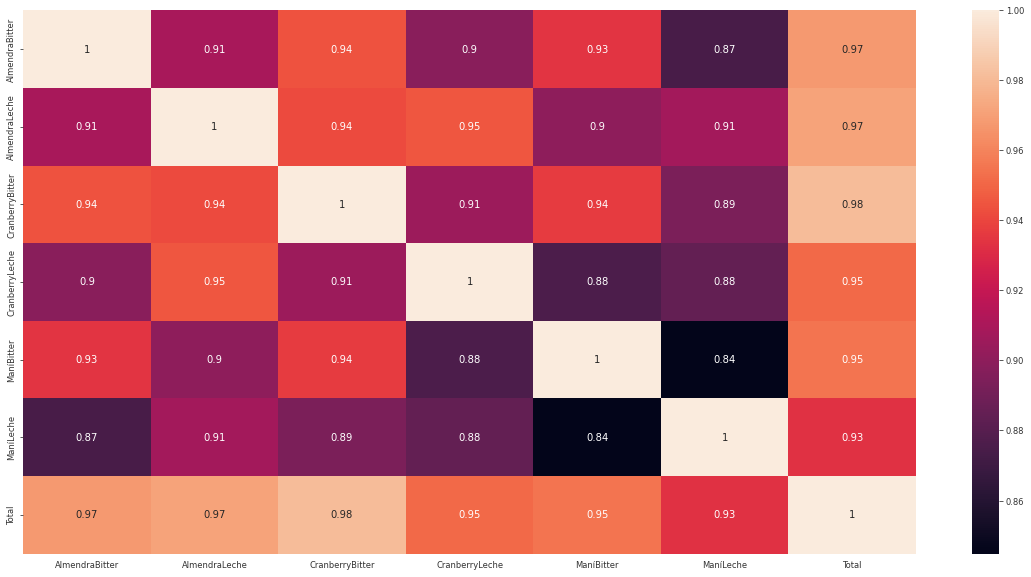

In [27]:
sns.heatmap(matrix.corr(), annot=True)

# 4) Modeling

In [28]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
from darts.metrics import mape, mae
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset

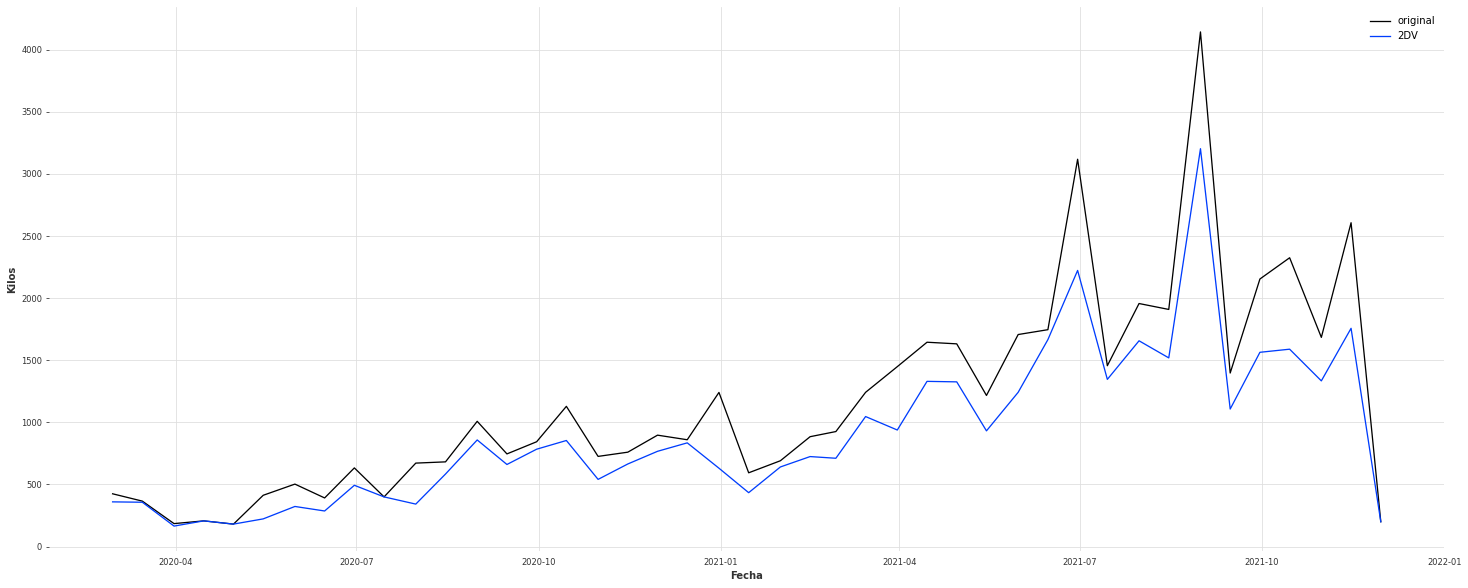

In [29]:
plt.subplots(figsize=(25,10))
sns.lineplot(data=df.set_index('Fecha').resample("SM", label='left').sum().reset_index(), x="Fecha", y="Kilos", label= 'original')
sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
#sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
#sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

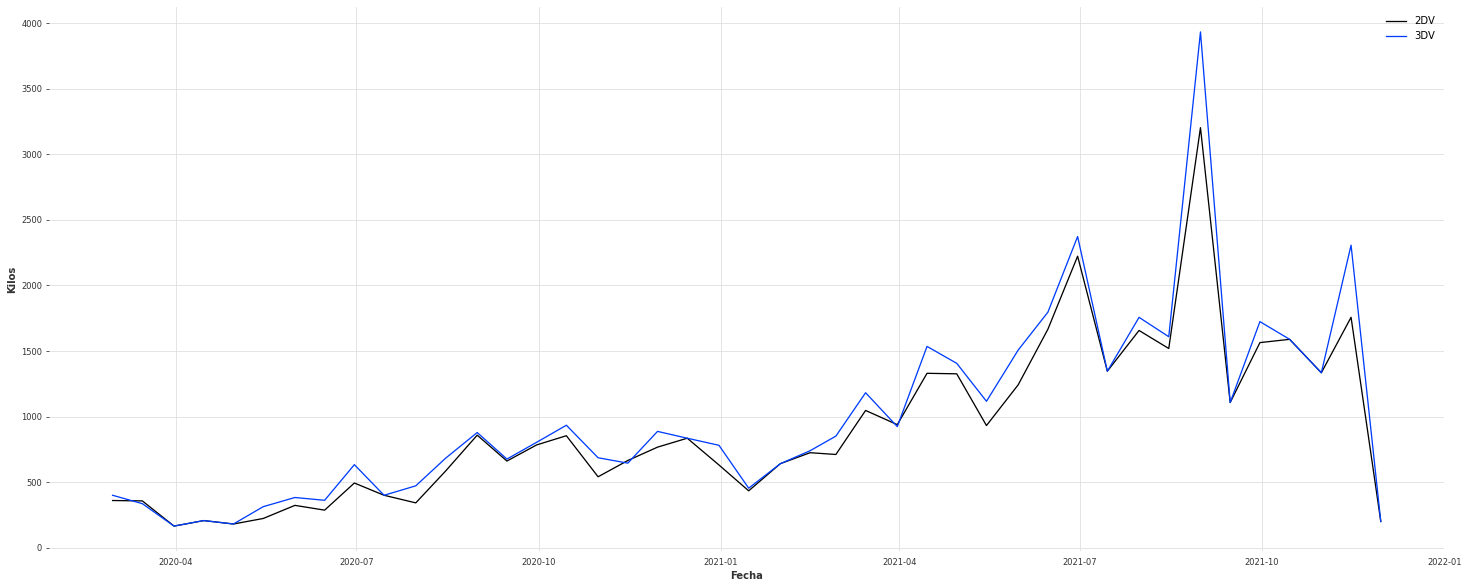

In [30]:
plt.subplots(figsize=(25,10))
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos")
sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
#sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
#sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

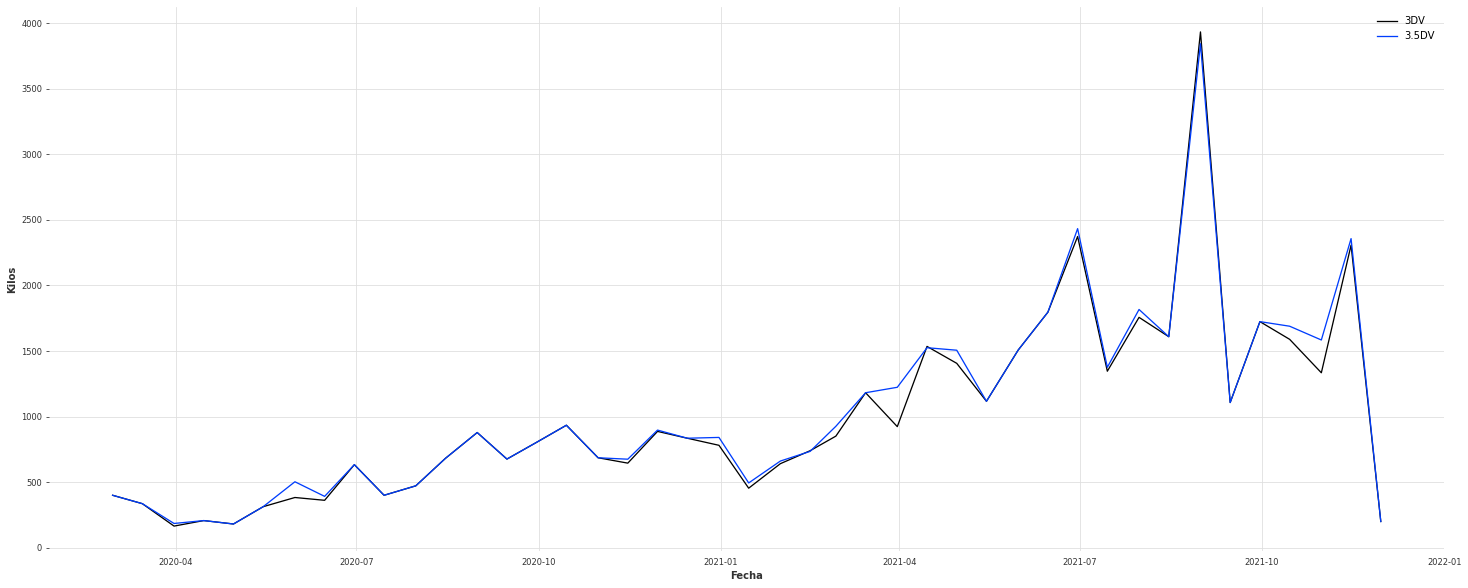

In [31]:
plt.subplots(figsize=(25,10))
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos")
#sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
#sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
data = df2dv[['Kilos']]
data.head()

,Kilos
0,360.0
1,357.0
2,165.0
3,207.0
4,181.0


In [33]:
residuals_abs_sum = {}
residuals_abs_mean = {}

for i in range(2,22):
    ts_dicomposition = seasonal_decompose(x=data, model='additive', period=i, two_sided=True)
    residual_estimate = ts_dicomposition.resid
    residuals_abs_sum[i] = np.abs(residual_estimate).sum()
    residuals_abs_mean[i] = np.abs(residual_estimate).mean()

pd.merge(
    pd.DataFrame.from_dict(residuals_abs_sum, orient='index', columns=["sum_abs_residuals"]),
    pd.DataFrame.from_dict(residuals_abs_mean, orient='index', columns=["mean_abs_residuals"]), left_index=True, right_index=True
).sort_values(by="mean_abs_residuals")

,sum_abs_residuals,mean_abs_residuals
20,1246.851125,54.210918
21,1627.239229,70.749532
19,1878.805540,75.152222
17,2453.590311,90.873715
16,2794.012891,103.481959
18,2823.883179,112.955327
15,3344.502667,115.327678
14,3355.802976,115.717344
2,5835.279762,142.323897
12,5113.000347,164.935495


residual mean = 70.74953169673663


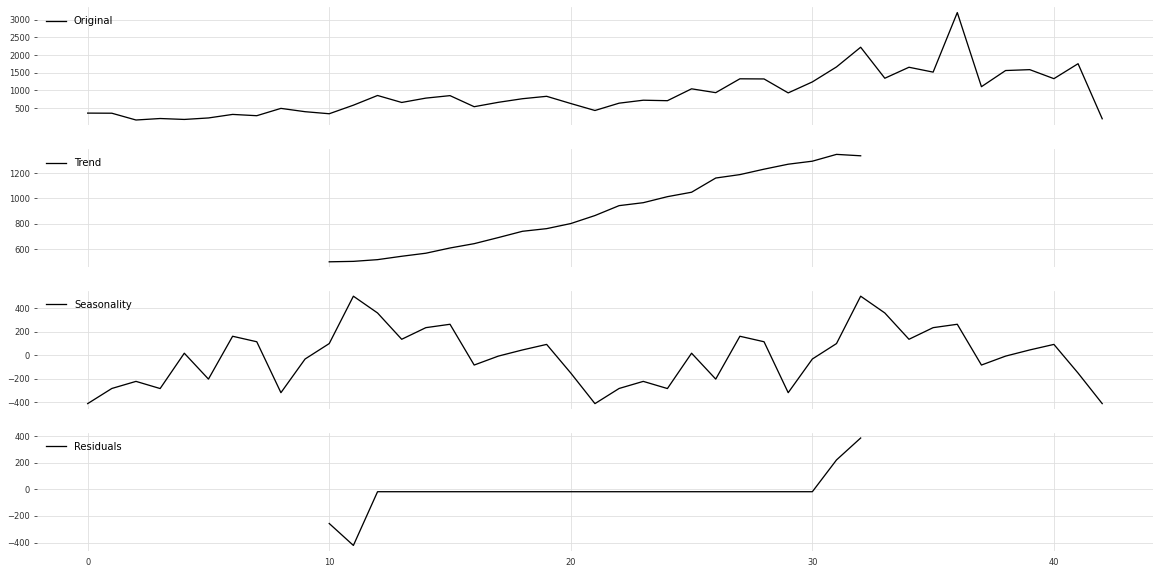

In [34]:
ts_dicomposition_a = seasonal_decompose(x=data, model='additive', period=20, two_sided=True)
trend_estimate_a = ts_dicomposition.trend
seasonal_estimate_a = ts_dicomposition.seasonal
residual_estimate_a = ts_dicomposition.resid

print(f"residual mean = {np.abs(residual_estimate).mean()}")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(data, label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_a, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_a, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_a, label='Residuals')
axes[3].legend(loc='upper left');

In [35]:
residuals_abs_mean = {}
residuals_abs_max = {}
residuals_abs_min = {}

for i in range(2,22):
    ts_dicomposition = seasonal_decompose(x=data, model='multiplicative', period=i, two_sided=True)
    residual_estimate = ts_dicomposition.resid
    residuals_abs_mean[i] = np.abs(residual_estimate).mean()
    residuals_abs_max[i] = np.abs(residual_estimate).max()
    residuals_abs_min[i] = np.abs(residual_estimate).min()

pd.merge(pd.merge(
    pd.DataFrame.from_dict(residuals_abs_mean, orient='index', columns=["mean_abs_residuals"]),
    pd.DataFrame.from_dict(residuals_abs_min, orient='index', columns=["min_abs_residuals"]),
    left_index=True, right_index=True),
    pd.DataFrame.from_dict(residuals_abs_max, orient='index', columns=["max_abs_residuals"]),
    left_index=True, right_index=True
).sort_values(by="mean_abs_residuals")

,mean_abs_residuals,min_abs_residuals,max_abs_residuals
18,0.957125,0.705169,1.209082
17,0.970814,0.615546,1.326082
19,0.972152,0.807714,1.136589
16,0.974447,0.698741,1.250154
15,0.976892,0.676346,1.277439
4,0.981123,0.669345,1.510414
5,0.987374,0.615221,1.679606
20,0.987430,0.826217,1.148643
9,0.988041,0.620988,1.452448
7,0.989469,0.565591,1.566901


In [36]:
ts_dicomposition_m = seasonal_decompose(x=data, model='multiplicative', period=20, two_sided=True)
trend_estimate_m = ts_dicomposition.trend
seasonal_estimate_m = ts_dicomposition.seasonal
residual_estimate_m = ts_dicomposition.resid

np.abs(residual_estimate).mean()

1.0032605496330331

residual mean = 1.0032605496330331


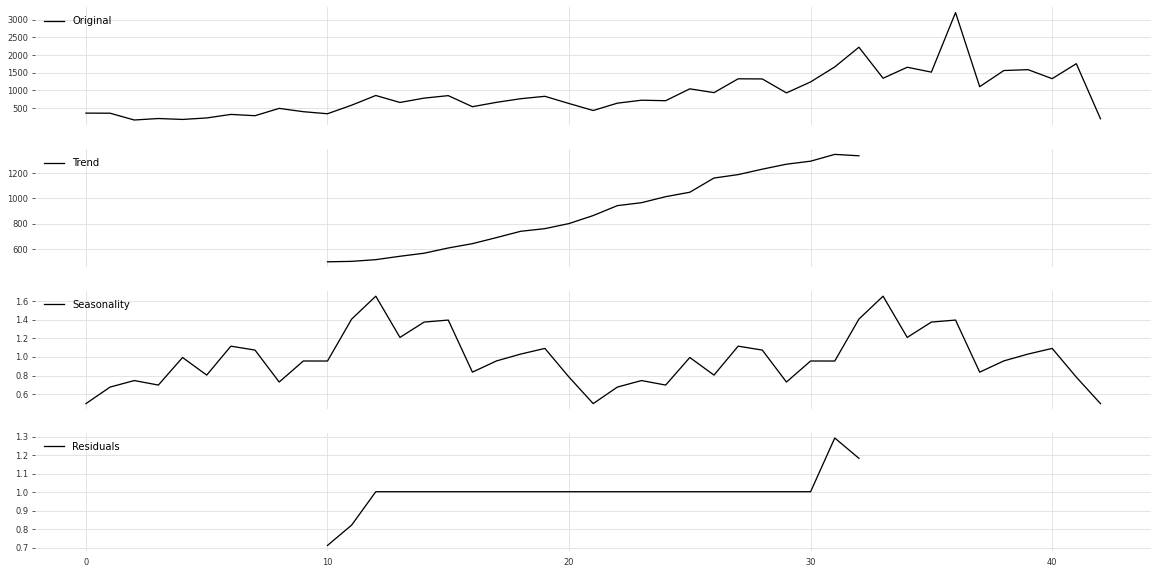

In [37]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

print(f"residual mean = {np.abs(residual_estimate).mean()}")

# First plot to the Original time series
axes[0].plot(data, label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_m, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_m, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_m, label='Residuals')
axes[3].legend(loc='upper left');

## ARIMA  - SEASONAL_ESTIMATE_A

In [38]:
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [39]:
ts = seasonal_estimate_a
print(ts.head())
print(ts.shape)


0   -413.317234
1   -284.364853
2   -223.983900
3   -284.993424
4     15.806576
Name: seasonal, dtype: float64
(43,)


In [40]:
adftest = adfuller(ts)
print(f"pvalue de adfuller es: {adftest[1]}")

pvalue de adfuller es: 0.00012988351294444708


Es menor a 0.05, por tanto la serie es estacionaria bajo el test de Augmented Dickey-Fulled

In [41]:
print(f"Largo de la serie es: {len(ts)}, y el 0.8*LargoSerie es {0.8*len(ts)}")
train, test = ts[:34], ts[34:]
print(f"Largo de TRAIN: {len(train)}. Largo de TEST: {len(test)}")

Largo de la serie es: 43, y el 0.8*LargoSerie es 34.4
Largo de TRAIN: 34. Largo de TEST: 9


In [44]:
p = range(0,1)
d = range(0,1)
q = range(0,1)


pdq = list(itertools.product(p,d,q))
print(len(pdq))
print(pdq)

25
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4)]


In [45]:
diccionarioo = {}

for i in pdq:
        try:
                model=sm.tsa.statespace.SARIMAX(train, order = (0,0,0), seasonal_order= i + (20,) ).fit()
                pred=model.predict(start=len(train), end=(len(ts)-1))
                error=mean_absolute_percentage_error(test, pred)
                print(i, error)
                diccionarioo[str(i)]=error
        except:
                continue


results = pd.DataFrame.from_dict(diccionarioo, orient='index', columns=["mape"]).sort_values(by="mape")
results

(0, 0, 0) 1.0
(0, 0, 1) 0.8562773639449905
(0, 0, 2) 1.0628965781970547
(0, 0, 3) 0.9352072614573087
(0, 0, 4) 1.0569506016840933
(1, 0, 0) 1.0093376859199656
(1, 0, 1) 1.134881935195014
(1, 0, 2) 0.8557334019334107
(1, 0, 3) 0.9478365703367453
(1, 0, 4) 0.9280913093313143
(2, 0, 0) 1.0262556497783286
(2, 0, 1) 1.1808858648467744
(2, 0, 2) 1.1255691593035269
(2, 0, 3) 0.8615041647518775
(2, 0, 4) 0.9833936840948652
(3, 0, 0) 1.0261662792819486
(3, 0, 1) 1.1809268830509034
(3, 0, 2) 1.0370194912384632
(3, 0, 3) 0.84868085459252
(3, 0, 4) 0.985389691856459
(4, 0, 0) 1.0260803934120912
(4, 0, 1) 1.180925680581158
(4, 0, 2) 1.0370229549174514
(4, 0, 3) 1.1300082038850374
(4, 0, 4) 0.9874713460464329


,mape
"(3, 0, 3)",0.848681
"(1, 0, 2)",0.855733
"(0, 0, 1)",0.856277
"(2, 0, 3)",0.861504
"(1, 0, 4)",0.928091
"(0, 0, 3)",0.935207
"(1, 0, 3)",0.947837
"(2, 0, 4)",0.983394
"(3, 0, 4)",0.985390
"(4, 0, 4)",0.987471


In [46]:
model=sm.tsa.statespace.SARIMAX(train, order = (0,0,0), seasonal_order= (3,0,4) +(10,) ).fit()
forecast=model.predict(start=len(train), end=(len(ts)-1))

MAPE: 2.1758821952577114


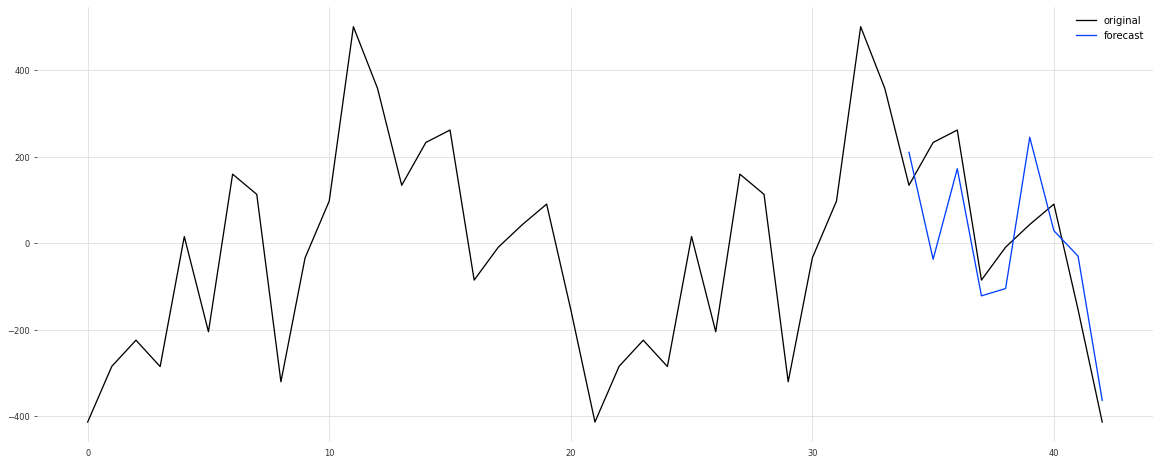

In [47]:
print(f"MAPE: {mean_absolute_percentage_error(test, forecast)}")
plt.subplots(figsize=(20,8))
ts.plot(label='original')
forecast.plot(label='forecast')
plt.legend()

## Regresión Lineal - TREND_ESTIMATE_A

In [48]:
trend_estimate_a.dropna()

10     500.876190
11     504.400000
12     517.923810
13     544.571429
14     568.571429
15     609.800000
16     643.866667
17     691.819048
18     741.314286
19     762.180952
20     802.276190
21     865.323810
22     943.371429
23     966.590476
24    1014.000000
25    1049.000000
26    1160.857143
27    1187.819048
28    1230.628571
29    1269.771429
30    1293.533333
31    1347.152381
32    1336.009524
Name: trend, dtype: float64

In [49]:
pendiente, intercepto = np.polyfit(list(range(10,33)),trend_estimate_a.dropna(), deg=1 )
(pendiente, intercepto)

(43.359919066440796, -17.007989836250403)

In [56]:
forecast_trend = [x*pendiente + intercepto for x in list(range(10,33))]
forecast_trend = pd.DataFrame(forecast_trend, index=list(range(10,33)), columns=['polyfit-2'])
forecast_trend

,polyfit-2
10,416.591201
11,459.951120
12,503.311039
13,546.670958
14,590.030877
15,633.390796
16,676.750715
17,720.110634
18,763.470553
19,806.830472


MAPE: 0.037222992338483404


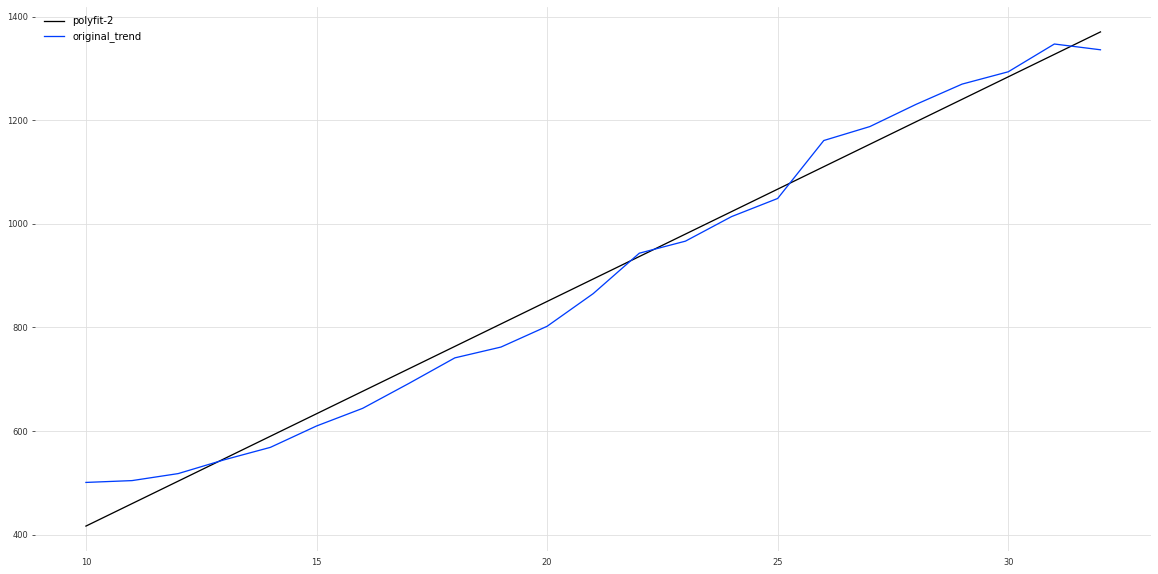

In [57]:
print(f"MAPE: {mean_absolute_percentage_error(trend_estimate_a.dropna(), forecast_trend)}")
forecast_trend.plot(label="forecast_trend")
trend_estimate_a.plot(label="original_trend")
plt.legend()

## UNIMOS AMBAS PARTES

In [58]:
#Parte TREND del mes 5 al mes 20
forecast_trend_20 = [x*pendiente + intercepto for x in list(range(10,42))]
forecast_trend_20 = pd.DataFrame(forecast_trend_20, index=list(range(10,42)), columns=['polyfit-2'])

#Parte SEASON del mes 5 al mes 20
season_estimate_a_20 = pd.DataFrame(seasonal_estimate_a[10:42]).rename(columns={'seasonal':'season_estimate_a_20'})

#Parte ORIGINAL
data_real = data[10:42]

#UNION
first_shot = pd.concat([forecast_trend_20, season_estimate_a_20, data_real],axis=1)
first_shot['forecast_first_shot'] = first_shot['polyfit-2']+first_shot['season_estimate_a_20']
first_shot


,polyfit-2,season_estimate_a_20,Kilos,forecast_first_shot
10,416.591201,97.992290,342.0,514.583491
11,459.951120,501.301814,584.0,961.252934
12,503.311039,358.482766,858.4,861.793805
13,546.670958,134.435147,661.0,681.106105
14,590.030877,233.435147,784.0,823.466024
15,633.390796,262.206576,854.0,895.597372
16,676.750715,-84.860091,541.0,591.890625
17,720.110634,-8.812472,665.0,711.298163
18,763.470553,43.692290,767.0,807.162844
19,806.830472,90.825624,835.0,897.656096


MAPE FIRST SHOT: 0.11845795673480522


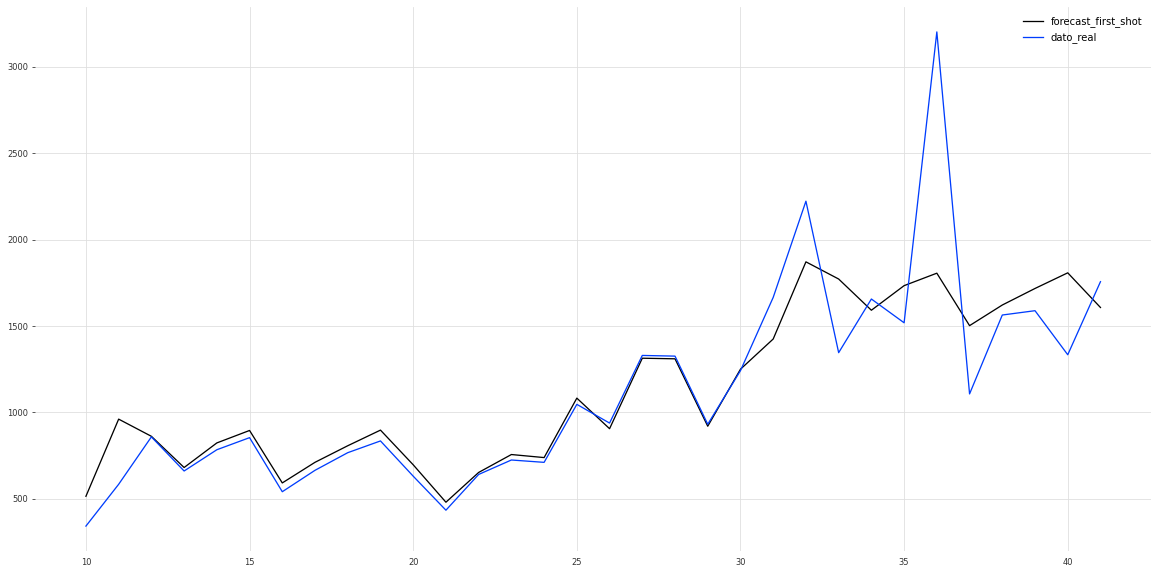

In [59]:
print(f"MAPE FIRST SHOT: {mean_absolute_percentage_error(first_shot['forecast_first_shot'], first_shot['Kilos'])}")

first_shot['forecast_first_shot'].plot(label="forecast_first_shot")
first_shot['Kilos'].plot(label="dato_real")
plt.legend()